# Improve SEDs

In this notebook we explore the idea of interpolating the 8-point SEDs to be able to generate PSFs closer to the ground truth.

In [1]:
interactive_plots = False
if interactive_plots:
    interactive = ''
else:
    interactive = 'svg'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf

import wf_psf

#import wf_psf.SimPSFToolkit as SimPSFToolkit
#import wf_psf.utils as wf_utils
#import wf_psf.tf_psf_field as tf_psf_field

# Plot style & colormap

import matplotlib as mpl
#import matplotlib.ticker as mtick
#import seaborn as sns
#from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#from mpl_toolkits.axes_grid1 import ImageGrid

#from IPython.display import display, HTML

# Tables in python notebooks
from tabulate import tabulate

# Interactive plots
import plotly
import plotly.graph_objects as go
import plotly.io as pio   
pio.kaleido.scope.mathjax = None

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


plot_style = {
    'mpl_toolkits.legacy_colorbar': False,
    'axes.formatter.use_mathtext': True,
    'text.usetex': False,
}
mpl.rcParams.update(plot_style)

plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

# Model Parameters

In [3]:
# Parameters
d_max = 2
max_order = 45
x_lims = [0, 1e3]
y_lims = [0, 1e3]
grid_points = [4, 4]
n_bins = 20
auto_init = True
verbose = True

oversampling_rate = 3.
output_Q = 3.

max_wfe_rms = 0.1
output_dim = 32
LP_filter_length = 2
euclid_obsc = True

pupil_diameter = 256

# Super resolved PSFs
super_out_Q = 1
super_out_res = 64

max_bins = 350

# Load Star SEDs

In [4]:
# SED folder path
SED_path = './../../../wf-psf/data/SEDs/save_SEDs/'
# Output saving path
output_folder = './../outputs/output-SEDs/'
plots_folder = './../outputs/plots/'

stellar_SEDs = np.load(SED_path + 'SEDs.npy', allow_pickle=True)
stellar_lambdas = np.load(SED_path + 'lambdas.npy', allow_pickle=True)
SED_name = ['O5V', 'B0V', 'B5-7V', 'A0V', 'A5V', 'F0V', 'F5V', 'G0V', 'G5V', 'K0V', 'K5V', 'M0V', 'M5V']
n_SEDs = len(SED_name)
# Create packed SEDs and lambdas lists
SED_list = []
for it in range(n_SEDs):
    concat_SED_wv = np.concatenate((stellar_lambdas.reshape(-1,1),
                                    stellar_SEDs[it,:].reshape(-1,1)), axis=1)
    SED_list.append(concat_SED_wv)
SED_np = np.array(SED_list)

# Generate Zernikes and Initialize PSF generator

In [5]:
# Generate Zernike maps
zernikes = wf_psf.utils.zernike_generator(n_zernikes=max_order, wfe_dim=pupil_diameter)

# Initialize PSF simulator
sim_PSF_toolkit = wf_psf.SimPSFToolkit(
    zernikes, max_order=max_order, max_wfe_rms=max_wfe_rms, oversampling_rate=oversampling_rate,
    output_Q=super_out_Q, output_dim=super_out_res, pupil_diameter=pupil_diameter, euclid_obsc=euclid_obsc,
    LP_filter_length=LP_filter_length)

# Initialize PSF field
gen_poly_fieldPSF = wf_psf.GenPolyFieldPSF(sim_PSF_toolkit, d_max=d_max,
                                    grid_points=grid_points, max_order=max_order,
                                    x_lims=x_lims, y_lims=y_lims, n_bins=max_bins,
                                    lim_max_wfe_rms=max_wfe_rms, verbose=verbose)

In [6]:
# Load C_poly
C_poly = np.load('../outputs/ground_truth/C_poly.npy', allow_pickle=True)
gen_poly_fieldPSF.C_poly = C_poly
# Load saved position
pos_np = np.load('../outputs/ground_truth/pos.npy', allow_pickle=True)

# Load Ground Truth PSFs

In [7]:
# Load data
gt_poly_psf_np = np.load('../outputs/ground_truth/gt_poly_psf.npy', allow_pickle=True)
zernike_coef_np = np.load('../outputs/ground_truth/gt_zernike_coef.npy', allow_pickle=True)

# Load 8-point-SED PSFs

In [8]:
# Load binned PSFs
binned_poly_psf =  np.load('../outputs/predictions/binned_poly_psf.npy',allow_pickle=True)

# Interpolate SED and generate PSFs

In [9]:
generate_PSF = False

In [10]:
SED_points_per_bin_list = [0,1,2]
n_bins = 8
gen_poly_fieldPSF.sim_psf_toolkit.SED_sigma = 0
gen_poly_fieldPSF.sim_psf_toolkit.extrapolate = True
gen_poly_fieldPSF.sim_psf_toolkit.SED_interp_kind = 'cubic'

if generate_PSF:
    # Generate all the polychromatic PSFs
    interp_poly_psf = []

    for points_per_bin in SED_points_per_bin_list:

        # Set right number of bins
        gen_poly_fieldPSF.n_bins = n_bins

        ########### add parameter to control the upsampling ############
        gen_poly_fieldPSF.sim_psf_toolkit.interp_pts_per_bin = points_per_bin

        psf_list = []
        # Generate polychromatic PSF at 3x Euclid resolution
        for it in range(n_SEDs):
            _psf, _, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[0, 0],
                                                                yv_flat=pos_np[0, 1],
                                                                SED=SED_list[it])
            psf_list.append(_psf)

        interp_poly_psf.append(psf_list)

    gen_poly_fieldPSF.sim_psf_toolkit.interp_pts_per_bin = 0
    np.save('../outputs/predictions/interp_extra_cubic_poly_psf.npy',np.array(interp_poly_psf),allow_pickle=True)

# Load numpy psf array
interp_poly_psf_np = np.load('../outputs/predictions/interp_extra_cubic_poly_psf.npy', allow_pickle=True)

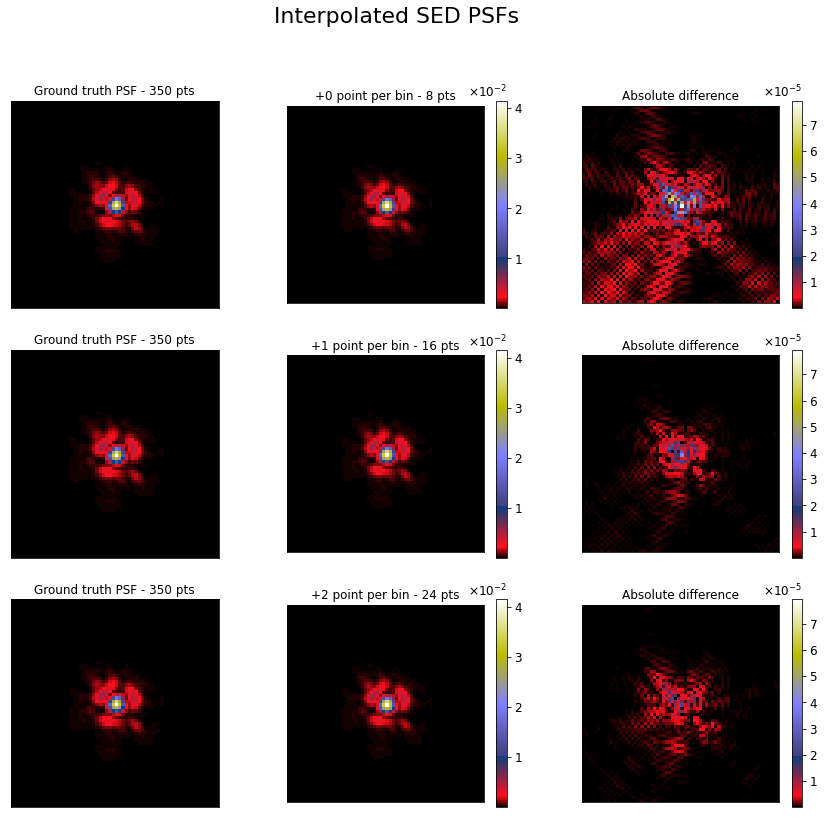

In [11]:
display_star = 0

fig, ax = plt.subplots(3, 3, figsize=(15,13), facecolor='white')
fig.suptitle('Interpolated SED PSFs', fontsize=22)

vmax_psf = np.max(gt_poly_psf_np[display_star,:,:])
vmax_dif = np.max(np.abs(gt_poly_psf_np[display_star,:,:] - interp_poly_psf_np[0,display_star]))

for itr, n_points in enumerate(SED_points_per_bin_list):
    im = ax[itr][0].imshow(gt_poly_psf_np[display_star,:,:], cmap='gist_stern', vmax=vmax_psf)
    ax[itr][0].set_title('Ground truth PSF - 350 pts')
    ax[itr][0].set_xticks([])
    ax[itr][0].set_yticks([])

    im = ax[itr][1].imshow(interp_poly_psf_np[itr,display_star],cmap='gist_stern', vmax=vmax_psf)
    ax[itr][1].set_title('+{} point per bin - {} pts'.format(n_points, n_bins*(n_points+1)))
    ax[itr][1].set_xticks([])
    ax[itr][1].set_yticks([])
    cbar = plt.colorbar(im, ax=ax[itr][1])
    cbar.formatter.set_powerlimits((0, 0))

    im = ax[itr][2].imshow(np.abs(interp_poly_psf_np[itr,display_star]-gt_poly_psf_np[display_star,:,:]),cmap='gist_stern', vmax=vmax_dif)
    ax[itr][2].set_title('Absolute difference')
    ax[itr][2].set_xticks([])
    ax[itr][2].set_yticks([])
    cbar = plt.colorbar(im, ax=ax[itr][2])
    cbar.formatter.set_powerlimits((0, 0))


#plt.savefig('../outputs/plots/interpolated_SED_PSFs.pdf')
plt.show()

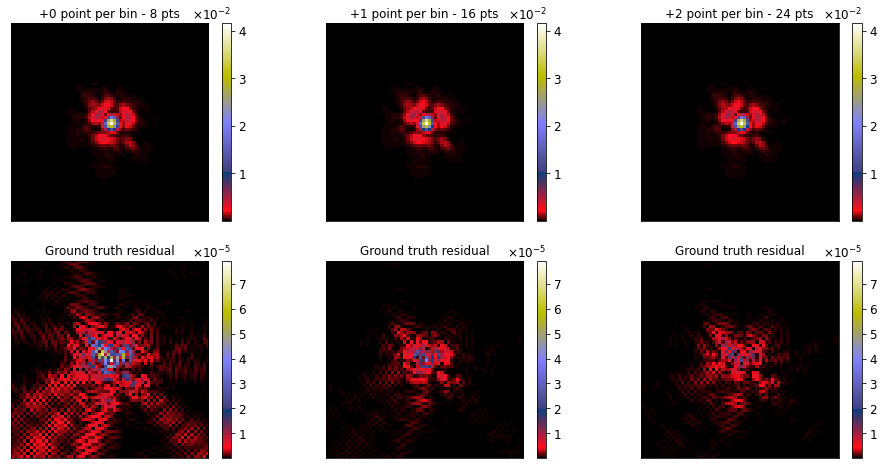

In [12]:
display_star = 0

fig, ax = plt.subplots(2, 3, figsize=(16,8), facecolor='white')
#fig.suptitle('Interpolated SED PSFs', fontsize=22)

vmax_psf = np.max(gt_poly_psf_np[display_star,:,:])
vmax_dif = np.max(np.abs(gt_poly_psf_np[display_star,:,:] - interp_poly_psf_np[0,display_star]))

for itr, n_points in enumerate(SED_points_per_bin_list):
    im = ax[0][itr].imshow(interp_poly_psf_np[itr,display_star],cmap='gist_stern', vmax=vmax_psf)
    ax[0][itr].set_title('+{} point per bin - {} pts'.format(n_points, n_bins*(n_points+1)))
    ax[0][itr].set_xticks([])
    ax[0][itr].set_yticks([])
    cbar = plt.colorbar(im, ax=ax[0][itr])
    cbar.formatter.set_powerlimits((0, 0))

    im = ax[1][itr].imshow(np.abs(interp_poly_psf_np[itr,display_star]-gt_poly_psf_np[display_star,:,:]),cmap='gist_stern', vmax=vmax_dif)
    ax[1][itr].set_title('Ground truth residual')
    ax[1][itr].set_xticks([])
    ax[1][itr].set_yticks([])
    cbar = plt.colorbar(im, ax=ax[1][itr])
    cbar.formatter.set_powerlimits((0, 0))


#plt.savefig('../outputs/plots/interpolated_SED_PSFs_noGT.pdf')
plt.show()

# PSF reconstruction errors

In [13]:
def get_RMSE(psf1, psf2):
    residual = np.sqrt(np.mean((psf1 - psf2)**2, axis=(0,1)))
    gt_mean  = np.sqrt(np.mean(psf1**2, axis=(0,1)))
    return residual, 100. * (residual/gt_mean)

In [14]:
abs_rmse_mat_interp = np.zeros((len(SED_points_per_bin_list), len(SED_name)))
rel_rmse_mat_interp = np.zeros((len(SED_points_per_bin_list), len(SED_name)))

for n_points in range(len(SED_points_per_bin_list)):
    for star_id in range(len(SED_name)):
        abs_rmse_mat_interp[n_points, star_id], rel_rmse_mat_interp[n_points, star_id] = get_RMSE(gt_poly_psf_np[star_id,:,:],interp_poly_psf_np[n_points,star_id])

In [15]:
rel_rmse_mean_interp = np.around(np.mean(rel_rmse_mat_interp, axis=1), decimals=2)
table = (np.around(rel_rmse_mat_interp, decimals=2)).tolist()

table.insert(0,SED_name.copy())
table[0].insert(0,'n_bins')
table[0].append('Avg RMSE')
for idx, n_points in enumerate(SED_points_per_bin_list):
    table[idx+1].insert(0, n_bins*(n_points+1))
    table[idx+1].append('->  '+str(rel_rmse_mean_interp[idx]))
print('\t\t\t\tRelative PSF error [%]')
print(tabulate(table))

				Relative PSF error [%]
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  --------
n_bins  O5V   B0V   B5-7V  A0V   A5V   F0V   F5V   G0V   G5V   K0V   K5V   M0V   M5V   Avg RMSE
8       0.31  0.31  0.26   0.25  0.23  0.19  0.17  0.16  0.15  0.14  0.11  0.11  0.12  ->  0.19
16      0.12  0.11  0.08   0.06  0.06  0.06  0.06  0.04  0.04  0.05  0.05  0.14  0.5   ->  0.11
24      0.09  0.09  0.08   0.09  0.08  0.06  0.05  0.06  0.05  0.04  0.04  0.06  0.27  ->  0.08
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  --------


# Interpolated SEDs visualisation

In [16]:
# Apply various interpolations to one SED and compare to ground truth
test_SED = SED_list[display_star]
filt_SED = gen_poly_fieldPSF.sim_psf_toolkit.filter_SED(test_SED,8)
interp_SED_1 = gen_poly_fieldPSF.sim_psf_toolkit.interp_SED(filt_SED, 1, 8)
interp_SED_2 = gen_poly_fieldPSF.sim_psf_toolkit.interp_SED(filt_SED, 2, 8)

fig = go.Figure()

fig.add_trace(go.Scatter(x=test_SED[:,0],y=test_SED[:,1]*len(test_SED),name='GT - 350 bins'))
fig.add_trace(go.Scatter(x=filt_SED[:,0],y=filt_SED[:,1]*len(filt_SED),name='Bins - 8 bins',marker=dict(size=15)))
fig.add_trace(go.Scatter(x=interp_SED_1[:,0],y=interp_SED_1[:,1]*sum(interp_SED_1[:,2])/interp_SED_1[:,2],name='Interp - 16 bins',marker=dict(size=11)))
fig.add_trace(go.Scatter(x=interp_SED_2[:,0],y=interp_SED_2[:,1]*sum(interp_SED_2[:,2])/interp_SED_2[:,2],name='Interp - 24 bins',mode='lines+markers',marker=dict(size=7)))

fig.update_layout(legend_title_text='SED:', title={'text':'SED before and after interpolation', 'x':0.5}, width=900, height=520)

fig.update_xaxes(title_text="Wavelength [nm]")
fig.update_yaxes(title_text="Flux unit")

#fig.write_image('../outputs/plots/SED_interp_vs_GT.pdf', engine='kaleido')
fig.show(interactive)


AttributeError: 'SimPSFToolkit' object has no attribute 'filter_SED'

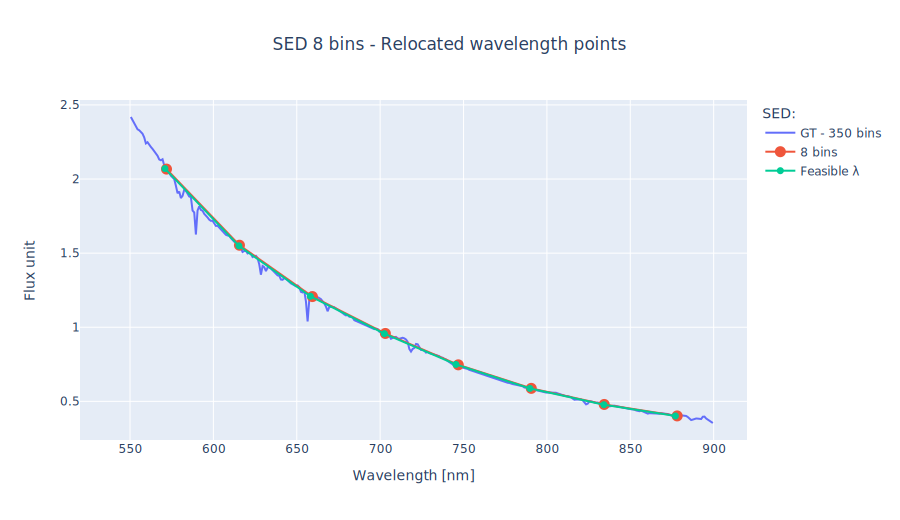

In [17]:
gen_poly_fieldPSF.sim_psf_toolkit.interp_pts_per_bin = 0
filt_SED_feasible_wv, filt_SED_feasible = gen_poly_fieldPSF.sim_psf_toolkit.calc_SED_wave_values(test_SED,8)

fig = go.Figure()

fig.add_trace(go.Scatter(x=test_SED[:,0],y=test_SED[:,1]*len(test_SED),name='GT - 350 bins'))
fig.add_trace(go.Scatter(x=filt_SED[:,0],y=filt_SED[:,1]*len(filt_SED),name='8 bins',marker=dict(size=11)))
fig.add_trace(go.Scatter(x=filt_SED_feasible_wv*1e3,y=filt_SED_feasible*len(filt_SED),name='Feasible λ',marker=dict(size=7)))

fig.update_xaxes(title_text="Wavelength [nm]")
fig.update_yaxes(title_text="Flux unit")

fig.update_layout(legend_title_text='SED:', title={'text':'SED 8 bins - Relocated wavelength points', 'x':0.5}, width=900, height=520,
                    xaxis=dict(range=[520, 920]))

#fig.write_image('../outputs/plots/SED_feasible_8_pts.pdf', engine='kaleido')
fig.show(interactive)

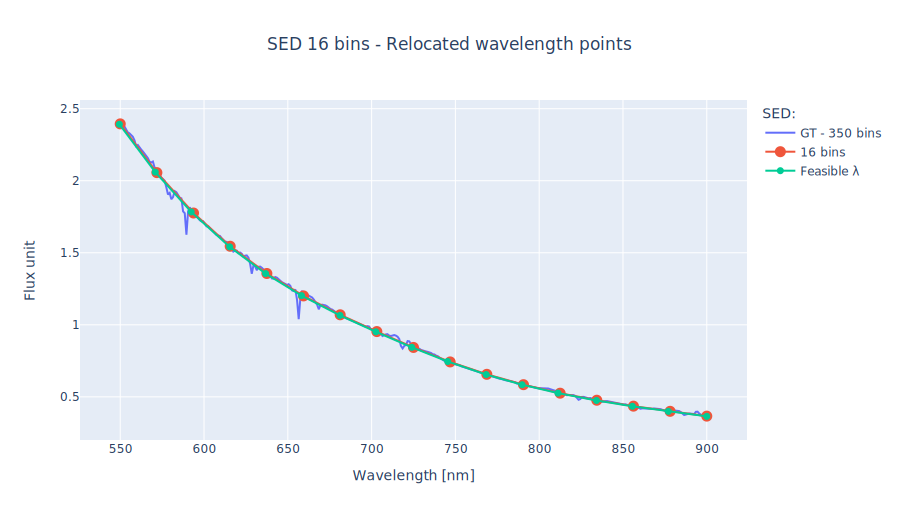

In [18]:
gen_poly_fieldPSF.sim_psf_toolkit.interp_pts_per_bin = 1
filt_SED_feasible_wv, filt_SED_feasible = gen_poly_fieldPSF.sim_psf_toolkit.calc_SED_wave_values(test_SED,8)

fig = go.Figure()

fig.add_trace(go.Scatter(x=test_SED[:,0],y=test_SED[:,1]*len(test_SED),name='GT - 350 bins'))
fig.add_trace(go.Scatter(x=interp_SED_1[:,0],y=interp_SED_1[:,1]*sum(interp_SED_1[:,2])/interp_SED_1[:,2],name='16 bins',marker=dict(size=11)))
fig.add_trace(go.Scatter(x=filt_SED_feasible_wv*1e3,y=filt_SED_feasible*sum(interp_SED_1[:,2])/interp_SED_1[:,2],name='Feasible λ',marker=dict(size=7)))

fig.update_xaxes(title_text="Wavelength [nm]")
fig.update_yaxes(title_text="Flux unit")

fig.update_layout(legend_title_text='SED:', title={'text':'SED 16 bins - Relocated wavelength points', 'x':0.5}, width=900, height=520)

#fig.write_image('../outputs/plots/SED_feasible_16_pts.pdf', engine='kaleido')
fig.show(interactive)

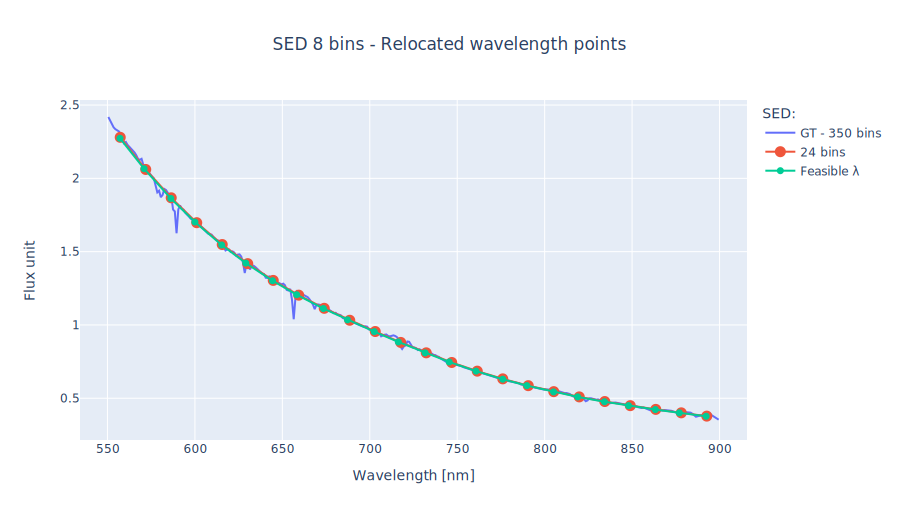

In [19]:
gen_poly_fieldPSF.sim_psf_toolkit.interp_pts_per_bin = 2
filt_SED_feasible_wv, filt_SED_feasible = gen_poly_fieldPSF.sim_psf_toolkit.calc_SED_wave_values(test_SED,8)

fig = go.Figure()

fig.add_trace(go.Scatter(x=test_SED[:,0],y=test_SED[:,1]*len(test_SED),name='GT - 350 bins'))
fig.add_trace(go.Scatter(x=interp_SED_2[:,0],y=interp_SED_2[:,1]*sum(interp_SED_2[:,2])/interp_SED_2[:,2],mode='lines+markers',name='24 bins',marker=dict(size=11)))
fig.add_trace(go.Scatter(x=filt_SED_feasible_wv*1e3,y=filt_SED_feasible*sum(interp_SED_2[:,2])/interp_SED_2[:,2],mode='lines+markers',name='Feasible λ',marker=dict(size=7)))

fig.update_xaxes(title_text="Wavelength [nm]")
fig.update_yaxes(title_text="Flux unit")

fig.update_layout(legend_title_text='SED:', title={'text':'SED 8 bins - Relocated wavelength points', 'x':0.5}, width=900, height=520)

#fig.write_image('../outputs/plots/SED_feasible_24_pts.pdf', engine='kaleido')
fig.show(interactive)

# Interpolating noisy SEDs

In this section we will repeat the experiment but adding noise to the 8 bin SED measurements before performing the interpolation.

In [17]:
generate_PSF = False

In [18]:
SED_points_per_bin_list = [0,1,2]
sigma_list = [0.1, 0.05, 0.02, 0.01, 0.005]
n_realisations = 10
n_bins = 8
gen_poly_fieldPSF.sim_psf_toolkit.SED_sigma = 0
gen_poly_fieldPSF.sim_psf_toolkit.extrapolate = True
gen_poly_fieldPSF.sim_psf_toolkit.SED_interp_kind = 'cubic'

if generate_PSF:
    noisy_interp_poly_psf = []

    for sigma in sigma_list:
        gen_poly_fieldPSF.sim_psf_toolkit.SED_sigma = sigma
        # Generate all the polychromatic PSFs
        interp_poly_psf = []

        for realisation in range(n_realisations):

            interp_poly_psf_realisation = []

            for points_per_bin in SED_points_per_bin_list:

                # Set right number of bins
                gen_poly_fieldPSF.n_bins = n_bins

                # Set number of points per bin to add
                gen_poly_fieldPSF.sim_psf_toolkit.interp_pts_per_bin = points_per_bin

                psf_list = []
                # Generate polychromatic PSF at 3x Euclid resolution
                for it in range(n_SEDs):
                    _psf, _, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[0, 0],
                                                                        yv_flat=pos_np[0, 1],
                                                                        SED=SED_list[it])
                    psf_list.append(_psf)

                interp_poly_psf_realisation.append(psf_list)

            interp_poly_psf.append(interp_poly_psf_realisation)
        
        noisy_interp_poly_psf.append(interp_poly_psf)

    gen_poly_fieldPSF.sim_psf_toolkit.interp_pts_per_bin = 0
    np.save('../outputs/predictions/noisy_interp_extra_cubic_poly_psf.npy',np.array(noisy_interp_poly_psf),allow_pickle=True)

# Load numpy PSF array
noisy_interp_poly_psf_np = np.load('../outputs/predictions/noisy_interp_extra_cubic_poly_psf.npy',allow_pickle=True)

In [19]:
abs_rmse_mat_noisy_interp = np.zeros((len(sigma_list),n_realisations,len(SED_points_per_bin_list), len(SED_name)))
rel_rmse_mat_noisy_interp = np.zeros((len(sigma_list),n_realisations,len(SED_points_per_bin_list), len(SED_name)))

for sigma_id in range(len(sigma_list)):
    for realisation in range(n_realisations):
        for n_points in range(len(SED_points_per_bin_list)):
            for star_id in range(len(SED_name)):
                abs_rmse_mat_noisy_interp[sigma_id, realisation, n_points, star_id], rel_rmse_mat_noisy_interp[sigma_id, realisation, n_points, star_id] = get_RMSE(gt_poly_psf_np[star_id,:,:],noisy_interp_poly_psf_np[sigma_id,realisation,n_points,star_id])

# Average for every star and for each set of 10 realisations
rel_rmse_mean_noisy_interp = np.mean(rel_rmse_mat_noisy_interp, axis=3)
rel_rmse_mean_noisy_interp = np.around(np.mean(rel_rmse_mean_noisy_interp, axis=1), decimals=2)

In [20]:
table = (np.around(rel_rmse_mean_noisy_interp.T, decimals=2)).tolist()

table.insert(0,[])
table.insert(0,sigma_list.copy())
table[0].append(0)
table[0].insert(0, 'sigma ->')
table[1].insert(0,'n_bins')
for idx, n_points in enumerate(SED_points_per_bin_list):
    table[idx+2].insert(0, n_bins*(n_points+1))
    table[idx+2].append(rel_rmse_mean_interp[idx])
print(tabulate(table))

--------  ----  ----  ----  ----  -----  ----
sigma ->  0.1   0.05  0.02  0.01  0.005  0
n_bins
8         0.7   0.35  0.23  0.2   0.19   0.19
16        0.71  0.36  0.18  0.14  0.11   0.11
24        0.69  0.34  0.16  0.11  0.09   0.08
--------  ----  ----  ----  ----  -----  ----


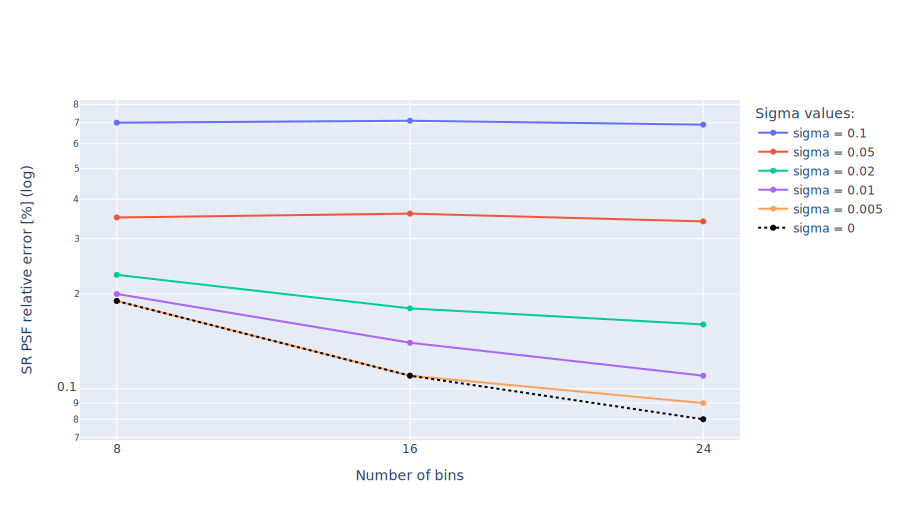

In [21]:
fig = go.Figure()
number_of_bins = [n_bins *(n_points + 1) for n_points in SED_points_per_bin_list]

for sigma_id in range(len(sigma_list)):
    fig.add_trace(go.Scatter(
        #legendgroup=SED_name[star_id],
        #legendgrouptitle_text=SED_name[star_id],
        x=number_of_bins,
        y=rel_rmse_mean_noisy_interp[sigma_id,:],
        name='sigma = {}'.format(sigma_list[sigma_id]),
    ))
# Sigma = 0, no Gaussian noise
fig.add_trace(go.Scatter(
        x=number_of_bins,
        y=rel_rmse_mean_interp,
        name='sigma = 0',
        line=dict(color='black', dash='dot')
    ))

fig.update_xaxes(tickvals=number_of_bins, title_text="Number of bins")
fig.update_yaxes(title_text="SR PSF relative error [%] (log)", type="log")
fig.update_layout(legend_title_text='Sigma values:', width=900, height=520)

#fig.write_image('../outputs/plots/noisy_interpolated_SED_PSF_errors.pdf', engine='kaleido')
fig.show(interactive)

# Noisy interpolated SED visualisation

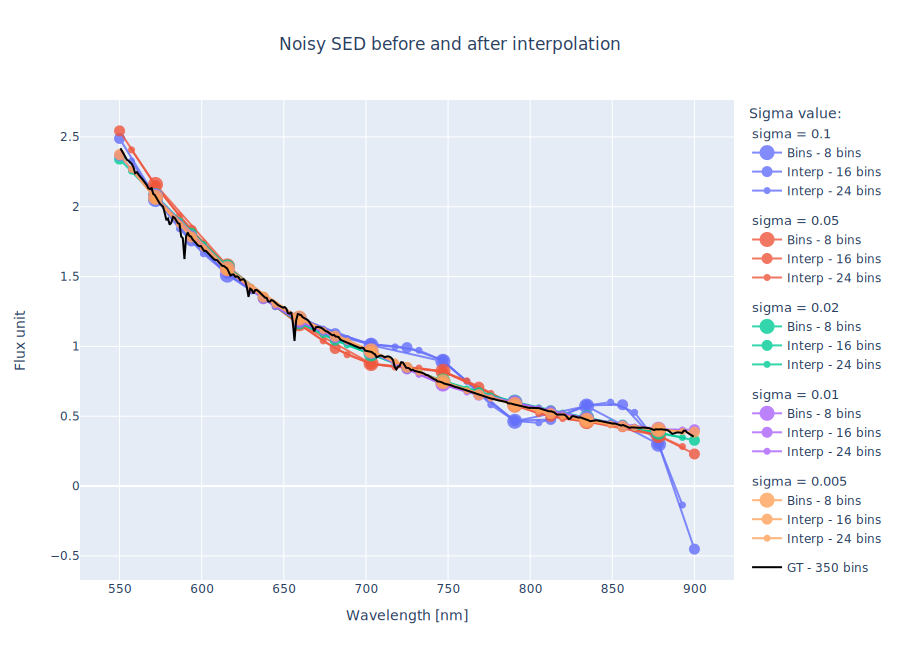

In [28]:
# Apply various interpolations to one SED and compare to ground truth
test_SED = SED_list[display_star]
filt_SED = gen_poly_fieldPSF.sim_psf_toolkit.filter_SED(test_SED,8)

interp_kind = 'cubic'
gen_poly_fieldPSF.sim_psf_toolkit.extrapolate = True

colors = plotly.colors.qualitative.Plotly

fig = go.Figure()

for idx,sigma in enumerate(sigma_list):
    filt_SED = gen_poly_fieldPSF.sim_psf_toolkit.filter_SED(test_SED,8)
    # Add noise and normalise
    filt_SED[:,1] = filt_SED[:,1] + gen_poly_fieldPSF.sim_psf_toolkit.SED_gen_noise(len(filt_SED), sigma)/len(filt_SED)
    filt_SED[:,1] = filt_SED[:,1]/np.sum(filt_SED[:,1])
    interp_SED_1 = gen_poly_fieldPSF.sim_psf_toolkit.interp_SED(filt_SED, 1, 8, interp_kind)
    interp_SED_2 = gen_poly_fieldPSF.sim_psf_toolkit.interp_SED(filt_SED, 2, 8, interp_kind)
    # Plot traces
    fig.add_trace(go.Scatter(x=filt_SED[:,0],y=filt_SED[:,1]*len(filt_SED),name='Bins - 8 bins',marker=dict(size=15),
                line=dict(color=colors[idx]),legendgroup=sigma,legendgrouptitle_text='sigma = {}'.format(sigma),opacity=0.8))
    fig.add_trace(go.Scatter(x=interp_SED_1[:,0],y=interp_SED_1[:,1]*sum(interp_SED_1[:,2])/interp_SED_1[:,2],name='Interp - 16 bins',marker=dict(size=11),
                line=dict(color=colors[idx]),legendgroup=sigma,legendgrouptitle_text='sigma = {}'.format(sigma),opacity=0.8))
    fig.add_trace(go.Scatter(x=interp_SED_2[:,0],y=interp_SED_2[:,1]*sum(interp_SED_2[:,2])/interp_SED_2[:,2],name='Interp - 24 bins',mode='lines+markers',marker=dict(size=7),
                line=dict(color=colors[idx]),legendgroup=sigma,legendgrouptitle_text='sigma = {}'.format(sigma),opacity=0.8))

fig.add_trace(go.Scatter(x=test_SED[:,0],y=test_SED[:,1]*len(test_SED),name='GT - 350 bins',
            line=dict(color='black')))

fig.update_layout(legend_title_text='Sigma value:', title={'text':'Noisy SED before and after interpolation', 'x':0.5}, width=900, height=660)

fig.update_xaxes(title_text="Wavelength [nm]")
fig.update_yaxes(title_text="Flux unit")

#fig.write_image('../outputs/plots/noisy_SED_interp_vs_GT.pdf', engine='kaleido')
fig.show(interactive)

# Final analysis

We will change some aspects of the simulation to see if the number of SED points has a meaningful impact even if the measurements are noisy. Wi will modify two aspects of the polychromatic PSF generation.

- Use linear interpolation instead of cubic splines for the new SED points.
- Make noise proportional to each bin value. Constant SED of 1/N assumption doesn't holds.

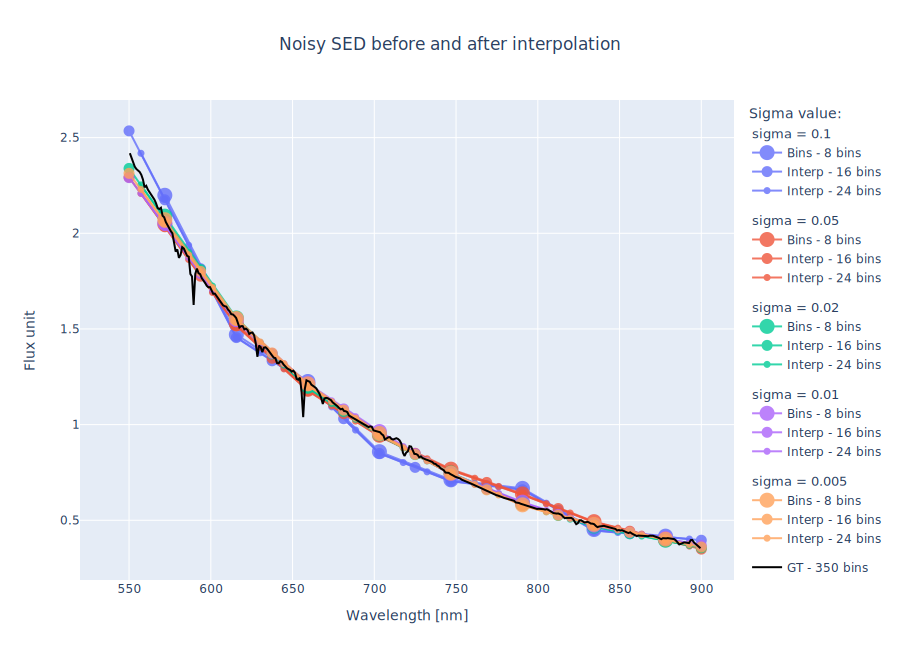

In [27]:
# Apply various interpolations to one SED and compare to ground truth
test_SED = SED_list[display_star]
filt_SED = gen_poly_fieldPSF.sim_psf_toolkit.filter_SED(test_SED,8)

interp_kind = 'linear'
# Do not allow extrapolation
gen_poly_fieldPSF.sim_psf_toolkit.extrapolate = True

colors = plotly.colors.qualitative.Plotly

fig = go.Figure()

for idx,sigma in enumerate(sigma_list):
    filt_SED = gen_poly_fieldPSF.sim_psf_toolkit.filter_SED(test_SED,8)
    # Add noise and normalise. Noise is scaled for each bin value.
    filt_SED[:,1] = filt_SED[:,1] + gen_poly_fieldPSF.sim_psf_toolkit.SED_gen_noise(len(filt_SED), sigma) * (filt_SED[:,1])
    filt_SED[:,1] = filt_SED[:,1]/np.sum(filt_SED[:,1])
    interp_SED_1 = gen_poly_fieldPSF.sim_psf_toolkit.interp_SED(filt_SED, 1, 8, interp_kind)
    interp_SED_2 = gen_poly_fieldPSF.sim_psf_toolkit.interp_SED(filt_SED, 2, 8, interp_kind)
    # Plot traces
    fig.add_trace(go.Scatter(x=filt_SED[:,0],y=filt_SED[:,1]*len(filt_SED),name='Bins - 8 bins',marker=dict(size=15),
                line=dict(color=colors[idx]),legendgroup=sigma,legendgrouptitle_text='sigma = {}'.format(sigma),opacity=0.8))
    fig.add_trace(go.Scatter(x=interp_SED_1[:,0],y=interp_SED_1[:,1]*sum(interp_SED_1[:,2])/interp_SED_1[:,2],name='Interp - 16 bins',marker=dict(size=11),
                line=dict(color=colors[idx]),legendgroup=sigma,legendgrouptitle_text='sigma = {}'.format(sigma),opacity=0.8))
    fig.add_trace(go.Scatter(x=interp_SED_2[:,0],y=interp_SED_2[:,1]*sum(interp_SED_2[:,2])/interp_SED_2[:,2],name='Interp - 24 bins',mode='lines+markers',marker=dict(size=7),
                line=dict(color=colors[idx]),legendgroup=sigma,legendgrouptitle_text='sigma = {}'.format(sigma),opacity=0.8))

fig.add_trace(go.Scatter(x=test_SED[:,0],y=test_SED[:,1]*len(test_SED),name='GT - 350 bins',
            line=dict(color='black')))

fig.update_layout(legend_title_text='Sigma value:', title={'text':'Noisy SED before and after interpolation', 'x':0.5}, width=900, height=660,
                    xaxis=dict(range=[520, 920]))

fig.update_xaxes(title_text="Wavelength [nm]")
fig.update_yaxes(title_text="Flux unit")

#fig.write_image('../outputs/plots/noisy_SED_interp_LINEAR_vs_GT.pdf', engine='kaleido')
fig.show(interactive)

# Generate PSFs by interpolating SED points linearly and with no extrapolation

In [22]:
generate_PSF = False

#### Without Noise

In [23]:
SED_points_per_bin_list = [0,1,2]
n_bins = 8
gen_poly_fieldPSF.sim_psf_toolkit.SED_sigma = 0
gen_poly_fieldPSF.sim_psf_toolkit.extrapolate = True
gen_poly_fieldPSF.sim_psf_toolkit.SED_interp_kind = 'linear'

if generate_PSF:
    # Generate all the polychromatic PSFs
    interp_poly_psf = []

    for points_per_bin in SED_points_per_bin_list:

        # Set right number of bins
        gen_poly_fieldPSF.n_bins = n_bins

        ########### add parameter to control the upsampling ############
        gen_poly_fieldPSF.sim_psf_toolkit.interp_pts_per_bin = points_per_bin

        psf_list = []
        # Generate polychromatic PSF at 3x Euclid resolution
        for it in range(n_SEDs):
            _psf, _, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[0, 0],
                                                                yv_flat=pos_np[0, 1],
                                                                SED=SED_list[it])
            psf_list.append(_psf)

        interp_poly_psf.append(psf_list)

    gen_poly_fieldPSF.sim_psf_toolkit.interp_pts_per_bin = 0
    np.save('../outputs/predictions/interp_extra_linear_poly_psf.npy',np.array(interp_poly_psf),allow_pickle=True)

# Load numpy psf array
interp_poly_psf_np = np.load('../outputs/predictions/interp_extra_linear_poly_psf.npy', allow_pickle=True)

In [24]:
abs_rmse_mat_interp = np.zeros((len(SED_points_per_bin_list), len(SED_name)))
rel_rmse_mat_interp = np.zeros((len(SED_points_per_bin_list), len(SED_name)))

for n_points in range(len(SED_points_per_bin_list)):
    for star_id in range(len(SED_name)):
        abs_rmse_mat_interp[n_points, star_id], rel_rmse_mat_interp[n_points, star_id] = get_RMSE(gt_poly_psf_np[star_id,:,:],interp_poly_psf_np[n_points,star_id])

In [25]:
rel_rmse_mean_interp = np.around(np.mean(rel_rmse_mat_interp, axis=1), decimals=2)
table = (np.around(rel_rmse_mat_interp, decimals=2)).tolist()

table.insert(0,SED_name.copy())
table[0].insert(0,'n_bins')
table[0].append('Avg RMSE')
for idx, n_points in enumerate(SED_points_per_bin_list):
    table[idx+1].insert(0, n_bins*(n_points+1))
    table[idx+1].append('->  '+str(rel_rmse_mean_interp[idx]))
print('\t\t\t\tRelative PSF error [%]')
print(tabulate(table))

				Relative PSF error [%]
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  --------
n_bins  O5V   B0V   B5-7V  A0V   A5V   F0V   F5V   G0V   G5V   K0V   K5V   M0V   M5V   Avg RMSE
8       0.31  0.31  0.26   0.25  0.23  0.19  0.17  0.16  0.15  0.14  0.11  0.11  0.12  ->  0.19
16      0.06  0.06  0.07   0.06  0.06  0.08  0.06  0.05  0.05  0.04  0.04  0.03  0.12  ->  0.06
24      0.13  0.13  0.1    0.09  0.08  0.05  0.05  0.05  0.05  0.04  0.04  0.03  0.11  ->  0.07
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  --------


#### With noise

In [26]:
generate_PSF = False

In [27]:
SED_points_per_bin_list = [0,1,2]
sigma_list = [0.1, 0.05, 0.02, 0.01, 0.005]
n_realisations = 10
n_bins = 8
gen_poly_fieldPSF.sim_psf_toolkit.SED_sigma = 0
gen_poly_fieldPSF.sim_psf_toolkit.SED_interp_kind = 'linear'
gen_poly_fieldPSF.sim_psf_toolkit.extrapolate = True

if generate_PSF:
    noisy_interp_poly_psf = []

    for sigma in sigma_list:
        gen_poly_fieldPSF.sim_psf_toolkit.SED_sigma = sigma
        # Generate all the polychromatic PSFs
        interp_poly_psf = []

        for realisation in range(n_realisations):

            interp_poly_psf_realisation = []

            for points_per_bin in SED_points_per_bin_list:

                # Set right number of bins
                gen_poly_fieldPSF.n_bins = n_bins

                # Set number of points per bin to add
                gen_poly_fieldPSF.sim_psf_toolkit.interp_pts_per_bin = points_per_bin

                psf_list = []
                # Generate polychromatic PSF at 3x Euclid resolution
                for it in range(n_SEDs):
                    _psf, _, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[0, 0],
                                                                        yv_flat=pos_np[0, 1],
                                                                        SED=SED_list[it])
                    psf_list.append(_psf)

                interp_poly_psf_realisation.append(psf_list)

            interp_poly_psf.append(interp_poly_psf_realisation)
        
        noisy_interp_poly_psf.append(interp_poly_psf)

    gen_poly_fieldPSF.sim_psf_toolkit.interp_pts_per_bin = 0
    np.save('../outputs/predictions/noisy_interp_extra_linear_poly_psf.npy',np.array(noisy_interp_poly_psf),allow_pickle=True)

# Load numpy PSF array
noisy_interp_poly_psf_np = np.load('../outputs/predictions/noisy_interp_extra_linear_poly_psf.npy',allow_pickle=True)

In [28]:
abs_rmse_mat_noisy_interp = np.zeros((len(sigma_list),n_realisations,len(SED_points_per_bin_list), len(SED_name)))
rel_rmse_mat_noisy_interp = np.zeros((len(sigma_list),n_realisations,len(SED_points_per_bin_list), len(SED_name)))

for sigma_id in range(len(sigma_list)):
    for realisation in range(n_realisations):
        for n_points in range(len(SED_points_per_bin_list)):
            for star_id in range(len(SED_name)):
                abs_rmse_mat_noisy_interp[sigma_id, realisation, n_points, star_id], rel_rmse_mat_noisy_interp[sigma_id, realisation, n_points, star_id] = get_RMSE(gt_poly_psf_np[star_id,:,:],noisy_interp_poly_psf_np[sigma_id,realisation,n_points,star_id])

# Average for every star and for each set of 10 realisations
rel_rmse_mean_noisy_interp = np.mean(rel_rmse_mat_noisy_interp, axis=3)
rel_rmse_mean_noisy_interp = np.around(np.mean(rel_rmse_mean_noisy_interp, axis=1), decimals=2)

In [29]:
table = (np.around(rel_rmse_mean_noisy_interp.T, decimals=2)).tolist()

table.insert(0,[])
table.insert(0,sigma_list.copy())
table[0].append(0)
table[0].insert(0, 'sigma ->')
table[1].insert(0,'n_bins')
for idx, n_points in enumerate(SED_points_per_bin_list):
    table[idx+2].insert(0, n_bins*(n_points+1))
    table[idx+2].append(rel_rmse_mean_interp[idx])
print(tabulate(table))

--------  ----  ----  ----  ----  -----  ----
sigma ->  0.1   0.05  0.02  0.01  0.005  0
n_bins
8         0.65  0.37  0.24  0.21  0.19   0.19
16        0.6   0.3   0.15  0.08  0.07   0.06
24        0.57  0.32  0.16  0.1   0.08   0.07
--------  ----  ----  ----  ----  -----  ----


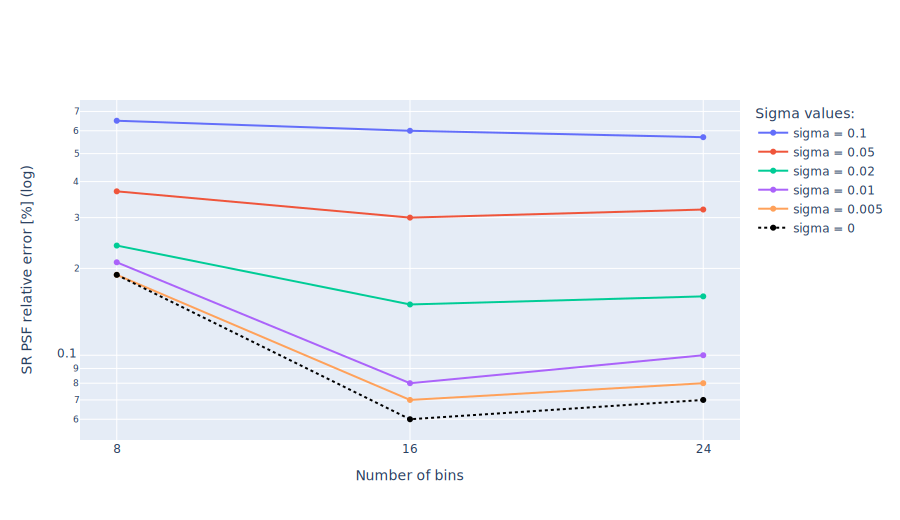

In [30]:
fig = go.Figure()
number_of_bins = [n_bins *(n_points + 1) for n_points in SED_points_per_bin_list]

for sigma_id in range(len(sigma_list)):
    fig.add_trace(go.Scatter(
        #legendgroup=SED_name[star_id],
        #legendgrouptitle_text=SED_name[star_id],
        x=number_of_bins,
        y=rel_rmse_mean_noisy_interp[sigma_id,:],
        name='sigma = {}'.format(sigma_list[sigma_id]),
    ))
# Sigma = 0, no Gaussian noise
fig.add_trace(go.Scatter(
        x=number_of_bins,
        y=rel_rmse_mean_interp,
        name='sigma = 0',
        line=dict(color='black', dash='dot')
    ))

fig.update_xaxes(tickvals=number_of_bins, title_text="Number of bins")
fig.update_yaxes(title_text="SR PSF relative error [%] (log)", type="log")
fig.update_layout(legend_title_text='Sigma values:', width=900, height=520)

#fig.write_image('../outputs/plots/noisy_interpolated_LINEAR_SED_PSF_errors.pdf', engine='kaleido')
fig.show(interactive)

# 32 bin SED - Interpolating 3 points per bin

In [31]:
generate_PSF = False

In [32]:
SED_points_per_bin_list = [3]
n_bins = 8
gen_poly_fieldPSF.sim_psf_toolkit.SED_sigma = 0
gen_poly_fieldPSF.sim_psf_toolkit.extrapolate = True
gen_poly_fieldPSF.sim_psf_toolkit.SED_interp_kind = 'linear'

if generate_PSF:
    # Generate all the polychromatic PSFs
    interp_poly_psf = []

    for points_per_bin in SED_points_per_bin_list:

        # Set right number of bins
        gen_poly_fieldPSF.n_bins = n_bins

        ########### add parameter to control the upsampling ############
        gen_poly_fieldPSF.sim_psf_toolkit.interp_pts_per_bin = points_per_bin

        psf_list = []
        # Generate polychromatic PSF at 3x Euclid resolution
        for it in range(n_SEDs):
            _psf, _, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[0, 0],
                                                                yv_flat=pos_np[0, 1],
                                                                SED=SED_list[it])
            psf_list.append(_psf)

        interp_poly_psf.append(psf_list)

    gen_poly_fieldPSF.sim_psf_toolkit.interp_pts_per_bin = 0
    np.save('../outputs/predictions/interp_32_extra_linear_poly_psf.npy',np.array(interp_poly_psf),allow_pickle=True)

# Load numpy psf array
interp_32_poly_psf_np = np.load('../outputs/predictions/interp_32_extra_linear_poly_psf.npy', allow_pickle=True)

In [33]:
abs_rmse_mat_interp_32 = np.zeros((len(SED_points_per_bin_list), len(SED_name)))
rel_rmse_mat_interp_32 = np.zeros((len(SED_points_per_bin_list), len(SED_name)))

for n_points in range(len(SED_points_per_bin_list)):
    for star_id in range(len(SED_name)):
        abs_rmse_mat_interp_32[n_points, star_id], rel_rmse_mat_interp_32[n_points, star_id] = get_RMSE(gt_poly_psf_np[star_id,:,:],interp_32_poly_psf_np[n_points,star_id])

In [34]:
rel_rmse_mean_interp_32 = np.around(np.mean(rel_rmse_mat_interp_32, axis=1), decimals=2)
table = (np.around(rel_rmse_mat_interp_32, decimals=2)).tolist()

table.insert(0,SED_name.copy())
table[0].insert(0,'n_bins')
table[0].append('Avg RMSE')
for idx, n_points in enumerate(SED_points_per_bin_list):
    table[idx+1].insert(0, n_bins*(n_points+1))
    table[idx+1].append('->  '+str(rel_rmse_mean_interp_32[idx]))
print('\t\t\t\tRelative PSF error [%]')
print(tabulate(table))

				Relative PSF error [%]
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  --------
n_bins  O5V   B0V   B5-7V  A0V   A5V   F0V   F5V   G0V   G5V   K0V   K5V   M0V   M5V   Avg RMSE
32      0.05  0.05  0.04   0.03  0.02  0.02  0.01  0.01  0.01  0.01  0.03  0.02  0.14  ->  0.03
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  --------


#### With noise

In [35]:
generate_PSF = False

In [36]:
SED_points_per_bin_list = [3]
sigma_list = [0.1, 0.05, 0.02, 0.01, 0.005]
n_realisations = 10
n_bins = 8
gen_poly_fieldPSF.sim_psf_toolkit.SED_sigma = 0
gen_poly_fieldPSF.sim_psf_toolkit.SED_interp_kind = 'linear'
gen_poly_fieldPSF.sim_psf_toolkit.extrapolate = True

if generate_PSF:
    noisy_interp_poly_psf = []

    for sigma in sigma_list:
        gen_poly_fieldPSF.sim_psf_toolkit.SED_sigma = sigma
        # Generate all the polychromatic PSFs
        interp_poly_psf = []

        for realisation in range(n_realisations):

            interp_poly_psf_realisation = []

            for points_per_bin in SED_points_per_bin_list:

                # Set right number of bins
                gen_poly_fieldPSF.n_bins = n_bins

                # Set number of points per bin to add
                gen_poly_fieldPSF.sim_psf_toolkit.interp_pts_per_bin = points_per_bin

                psf_list = []
                # Generate polychromatic PSF at 3x Euclid resolution
                for it in range(n_SEDs):
                    _psf, _, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[0, 0],
                                                                        yv_flat=pos_np[0, 1],
                                                                        SED=SED_list[it])
                    psf_list.append(_psf)

                interp_poly_psf_realisation.append(psf_list)

            interp_poly_psf.append(interp_poly_psf_realisation)
        
        noisy_interp_poly_psf.append(interp_poly_psf)

    gen_poly_fieldPSF.sim_psf_toolkit.interp_pts_per_bin = 0
    np.save('../outputs/predictions/noisy_interp_32_extra_linear_poly_psf.npy',np.array(noisy_interp_poly_psf),allow_pickle=True)

# Load numpy PSF array
noisy_interp_32_poly_psf_np = np.load('../outputs/predictions/noisy_interp_32_extra_linear_poly_psf.npy',allow_pickle=True)

In [37]:
abs_rmse_mat_noisy_interp_32 = np.zeros((len(sigma_list),n_realisations,len(SED_points_per_bin_list), len(SED_name)))
rel_rmse_mat_noisy_interp_32 = np.zeros((len(sigma_list),n_realisations,len(SED_points_per_bin_list), len(SED_name)))

for sigma_id in range(len(sigma_list)):
    for realisation in range(n_realisations):
        for n_points in range(len(SED_points_per_bin_list)):
            for star_id in range(len(SED_name)):
                abs_rmse_mat_noisy_interp_32[sigma_id, realisation, n_points, star_id], rel_rmse_mat_noisy_interp_32[sigma_id, realisation, n_points, star_id] = get_RMSE(gt_poly_psf_np[star_id,:,:],noisy_interp_32_poly_psf_np[sigma_id,realisation,n_points,star_id])

# Average for every star and for each set of 10 realisations
rel_rmse_mean_noisy_interp_32 = np.mean(rel_rmse_mat_noisy_interp_32, axis=3)
rel_rmse_mean_noisy_interp_32 = np.around(np.mean(rel_rmse_mean_noisy_interp_32, axis=1), decimals=2)

In [38]:
table = (np.around(rel_rmse_mean_noisy_interp_32.T, decimals=2)).tolist()

table.insert(0,[])
table.insert(0,sigma_list.copy())
table[0].append(0)
table[0].insert(0, 'sigma ->')
table[1].insert(0,'n_bins')
for idx, n_points in enumerate(SED_points_per_bin_list):
    table[idx+2].insert(0, n_bins*(n_points+1))
    table[idx+2].append(rel_rmse_mean_interp_32[idx])
print(tabulate(table))

--------  ---  ----  ----  ----  -----  ----
sigma ->  0.1  0.05  0.02  0.01  0.005  0
n_bins
32        0.6  0.31  0.13  0.08  0.05   0.03
--------  ---  ----  ----  ----  -----  ----


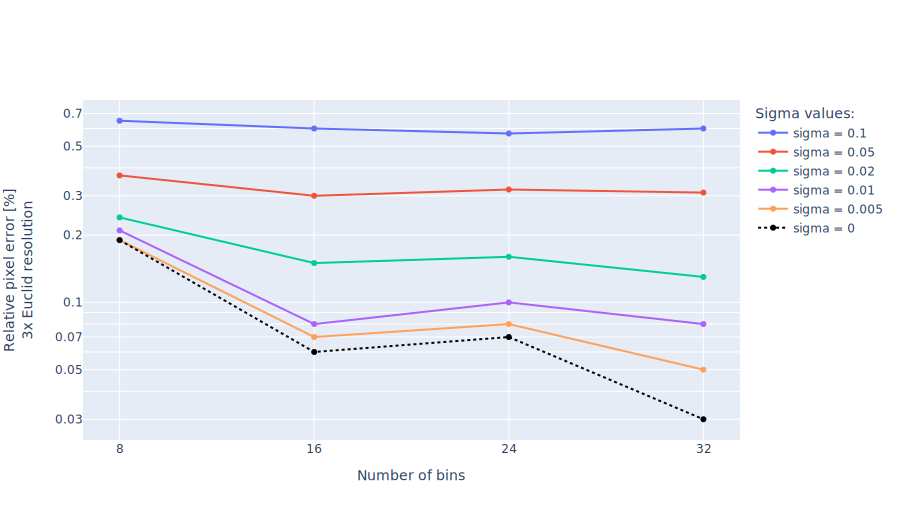

In [55]:
fig = go.Figure()
SED_points_per_bin_list = [0,1,2,3]
number_of_bins = [n_bins *(n_points + 1) for n_points in SED_points_per_bin_list]

for sigma_id in range(len(sigma_list)):
    fig.add_trace(go.Scatter(
        #legendgroup=SED_name[star_id],
        #legendgrouptitle_text=SED_name[star_id],
        x=number_of_bins,
        y=np.hstack((rel_rmse_mean_noisy_interp[sigma_id,:], rel_rmse_mean_noisy_interp_32[sigma_id,0])),
        name='sigma = {}'.format(sigma_list[sigma_id]),
    ))
# Sigma = 0, no Gaussian noise
fig.add_trace(go.Scatter(
        x=number_of_bins,
        y=np.hstack((rel_rmse_mean_interp, rel_rmse_mean_interp_32)),
        name='sigma = 0',
        line=dict(color='black', dash='dot')
    ))

fig.update_xaxes(tickvals=number_of_bins, title_text="Number of bins")
fig.update_yaxes(title_text="Relative pixel error [%]<br>3x Euclid resolution", type="log") #, tickformat="f")
fig.update_layout(
    legend_title_text='Sigma values:',
    width=900,
    height=520,
    yaxis = dict(
        tickmode = 'array',
        tickvals = [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        ticktext = ['0.03', '', '0.05', '', '0.07', '', '', '0.1', '0.2', '0.3', '', '0.5', '', '0.7', '']
    )
)

# fig.write_image('../outputs/plots/NewStyle_noisy_interpolated_32_bins_LINEAR_SED_PSF_errors.pdf', engine='kaleido')
fig.show(interactive)